In [26]:
# Importing required libraries
from typing import Dict
from math import pow, ceil
import numpy as np
import math

# Constants
DISCOUNT_RATE = 0.05  # Discount rate for NPV calculations

# Helper function to calculate present value (PV) of a series of cash flows
def calculate_present_value(annual_cost: float, years: int = 10, discount_rate: float = DISCOUNT_RATE) -> float:
    pv = annual_cost * ((1 - pow(1 + discount_rate, -years)) / discount_rate)
    return pv

# 1. Function to calculate initial setup cost for the battery swapping station
def calculate_swapping_station_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost"] +
        params["charger_cost"] +
        params["land_cost"] +
        params["service_vehicle_cost"] +
        params["backup_power_system_cost"] +
        params["battery_management_software_cost"] +
        params["electrical_grid_connection_cost"] +
        params["infrastructure_construction_cost"]
    )
    print(params)
    return initial_cost

# 2. Function to calculate initial setup cost for the home charging setup
def calculate_home_charging_setup_cost(params: Dict[str, float]) -> float:
    initial_cost = (
        params["battery_cost_per_vehicle"] +
        params["charger_cost_per_vehicle"] +
        params["installation_cost_per_charger"] +
        params["miscellaneous_initial_costs"]
    )
    return initial_cost

# 3. Function to calculate annual operational costs for the battery swapping station
def calculate_swapping_station_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["maintenance_cost"] +
        params["worker_salaries"] +
        params["backup_power_cost"] +
        params["battery_replacement_cost"] +
        params["miscellaneous_operational_costs"] +
        params["depreciation_costs"]
    )
    print(params)
    return annual_cost

# 4. Function to calculate annual operational costs for the home charging setup
def calculate_home_charging_annual_operational_cost(params: Dict[str, float]) -> float:
    annual_cost = (
        params["battery_replacement_cost_per_vehicle"] +
        params["electricity_cost_per_vehicle"] +
        params["maintenance_cost"] +
        params["miscellaneous_operational_costs"]
    )
    return annual_cost

# 5. Function to calculate total 10-year cost for each setup (initial cost + present value of operational costs)
def calculate_total_10_year_cost(initial_cost: float, annual_operational_cost: float, years: int = 10, discount_rate: float = DISCOUNT_RATE) -> float:
    operational_cost_pv = calculate_present_value(annual_operational_cost, years,discount_rate=discount_rate)
    total_cost = initial_cost + operational_cost_pv
    return total_cost

# 6. Function to calculate profit based on swap fee, total annual swaps, and total 10-year cost
def calculate_profit(swap_fee: float, total_annual_swaps: int, total_10_year_cost: float) -> float:
    total_revenue = swap_fee * total_annual_swaps * 10
    profit = total_revenue - total_10_year_cost
    return profit

# 7. Function to calculate the break-even swap fee based on the total 10-year cost and desired profit
def calculate_break_even_swap_fee(total_10_year_cost: float, total_annual_swaps: int, desired_profit: float = 0) -> float:
    break_even_fee = (total_10_year_cost + desired_profit) / (total_annual_swaps*10)
    return break_even_fee

# 8. 

def scale_vehicle_demand(vehicles_per_hour, target_vehicle_count):
    """
    Scale the vehicles_per_hour array to match a new target vehicle count.
    """
    current_vehicle_count = vehicles_per_hour.sum()
    scaling_factor = target_vehicle_count / current_vehicle_count
    scaled_demand = np.round(vehicles_per_hour * scaling_factor).astype(int)
    
    # Adjust the scaled demand to ensure it matches exactly the target vehicle count
    difference = target_vehicle_count - scaled_demand.sum()
    if difference > 0:
        for i in range(difference):
            scaled_demand[i % len(scaled_demand)] += 1
    elif difference < 0:
        for i in range(-difference):
            scaled_demand[i % len(scaled_demand)] -= 1
    
    return scaled_demand

# 9.
def calculate_batteries_needed(vehicles_per_hour, charging_time, total_service_rate, max_wait_time):
    """
    Calculate the required number of batteries, considering peak hours, allowed wait time, and swap slots.
    """
    total_batteries_in_use = 0
    batteries_in_queue = 0
    max_batteries = 0
    batteries_being_charged = [0] * int(charging_time)  # Track batteries charging each hour

    for hour, demand in enumerate(vehicles_per_hour):
        # Calculate the waiting time based on current queue and demand
        actual_wait_time = max(0, (demand - total_service_rate) / total_service_rate) * swap_time
        
        # If the demand exceeds our service rate and wait time exceeds the max allowed, we need more batteries or slots
        if actual_wait_time > max_wait_time:
            additional_slots_needed = math.ceil((demand - total_service_rate * max_wait_time) / (1 / swap_time))
            num_slots_needed = max(num_slots, additional_slots_needed)
            total_service_rate = num_slots_needed / swap_time  # Update the total service rate

        # Queue management: add batteries in queue if demand exceeds service rate
        if demand > total_service_rate:
            batteries_in_queue += demand - total_service_rate
        else:
            batteries_in_queue = max(0, batteries_in_queue - (total_service_rate - demand))

        # Update batteries in use and track max requirement
        total_batteries_in_use += demand
        max_batteries = max(max_batteries, total_batteries_in_use + batteries_in_queue)

        # Shift charged batteries by 1 hour and return the oldest batch of charged batteries to the pool
        returning_batteries = batteries_being_charged.pop(0)
        total_batteries_in_use -= returning_batteries  # Reduce in-use batteries by the charged amount
        batteries_being_charged.append(demand)  # New batteries going for charging after this hour

    # Return the maximum number of batteries required to meet demand without exceeding the wait time
    return math.ceil(max_batteries)



# Example Usage
# Define all cost parameters

# Original vehicle demand profile (total 76 vehicles)
vehicles_per_hour = np.array([1, 1, 0, 0, 0, 1, 1, 2, 4, 4, 5, 5, 6, 5, 10, 3, 4, 8, 5, 4, 3, 2, 1, 1])
swap_time = 0.25  # Hours per swap (6 minutes)
charging_time = 6  # Hours to fully charge
max_wait_time = 0.083  # Hours (5 minutes)
num_slots = 8  # Number of slots for simultaneous swaps
number_of_chargers = 13
num_workers = 4
lead_acid_battery_life=1
lithium_ion_battery_life=3

# Example usage
target_vehicle_count = 76  # Desired new total vehicle count
scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, target_vehicle_count)

# Run the calculation with scaled demand
total_service_rate = num_slots / swap_time
batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time)+4


swapping_station_params = {
    "battery_cost": 40000 * batteries_needed,
    "charger_cost": 1500 * number_of_chargers,
    "land_cost": 187500,
    "service_vehicle_cost": 120000,
    "backup_power_system_cost": 70000,
    "battery_management_software_cost": 295000,
    "electrical_grid_connection_cost": 50000,
    "infrastructure_construction_cost": 300000,
    "maintenance_cost": 50000,
    "worker_salaries": 15000 * num_workers * 12,
    "battery_replacement_cost": 40000 * batteries_needed / lithium_ion_battery_life,
    "backup_power_cost": 36500,
    "miscellaneous_operational_costs": 30000,
    "depreciation_costs": 92900,
    "batteries_needed": batteries_needed
}

home_charging_params = {
    "battery_cost_per_vehicle": 32000,
    "charger_cost_per_vehicle": 1500,
    "installation_cost_per_charger": 1000,
    "miscellaneous_initial_costs": 5000,
    "battery_replacement_cost_per_vehicle": 32000/lead_acid_battery_life,
    "electricity_cost_per_vehicle": 6000,
    "maintenance_cost": 1000,
    "miscellaneous_operational_costs": 2000
}

# Define other inputs
total_annual_swaps = target_vehicle_count * 365 
desired_profit = 0

# Calculate costs for battery swapping station
initial_setup_cost_swapping = calculate_swapping_station_setup_cost(swapping_station_params)
annual_operational_cost_swapping = calculate_swapping_station_annual_operational_cost(swapping_station_params)
total_10_year_cost_swapping = calculate_total_10_year_cost(initial_setup_cost_swapping, annual_operational_cost_swapping)

# Calculate costs for home charging setup
initial_setup_cost_home = calculate_home_charging_setup_cost(home_charging_params)
annual_operational_cost_home = calculate_home_charging_annual_operational_cost(home_charging_params)
total_10_year_cost_home = calculate_total_10_year_cost(initial_setup_cost_home, annual_operational_cost_home)

# Calculate profit and break-even swap fee
swap_fee = 53 # Example swap fee for testing
profit = calculate_profit(swap_fee, total_annual_swaps, total_10_year_cost_swapping)
break_even_fee = calculate_break_even_swap_fee(total_10_year_cost_swapping, total_annual_swaps, desired_profit)


# Print results
print("Total Batteries Required for Daily Demand:", batteries_needed)
print("Initial Setup Cost (Swapping Station):", initial_setup_cost_swapping)
print("Annual Operational Cost (Swapping Station):", annual_operational_cost_swapping)
print("Total 10-Year Cost (Swapping Station):", total_10_year_cost_swapping)
print("Initial Setup Cost (Home Charging):", initial_setup_cost_home)
print("Annual Operational Cost (Hom Charging):", annual_operational_cost_home)
print("Total 10-Year Cost (Home Charging):", total_10_year_cost_home)
print("Profit with swap fee of", swap_fee, ":", profit)
print("Break-Even Swap Fee (desired profit =", desired_profit, "):", break_even_fee)



{'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000.0, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900, 'batteries_needed': 45}
{'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000.0, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900, 'batteries_needed': 45}
Total Batteries Required for Daily D

In [ ]:
# {'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
# {'battery_cost': 1800000, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 600000, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
# Total Batteries Required for Daily Demand: 45
# Initial Setup Cost (Swapping Station): 2842000
# Annual Operational Cost (Swapping Station): 1529400
# Total 10-Year Cost (Swapping Station): 14651621.40069526
# Initial Setup Cost (Home Charging): 39500
# Annual Operational Cost (Hom Charging): 41000.0
# Total 10-Year Cost (Home Charging): 356091.1320965775
# Profit with swap fee of 52.81766907244146 : 0.0
# Break-Even Swap Fee (desired profit = 0 ): 52.81766907244146

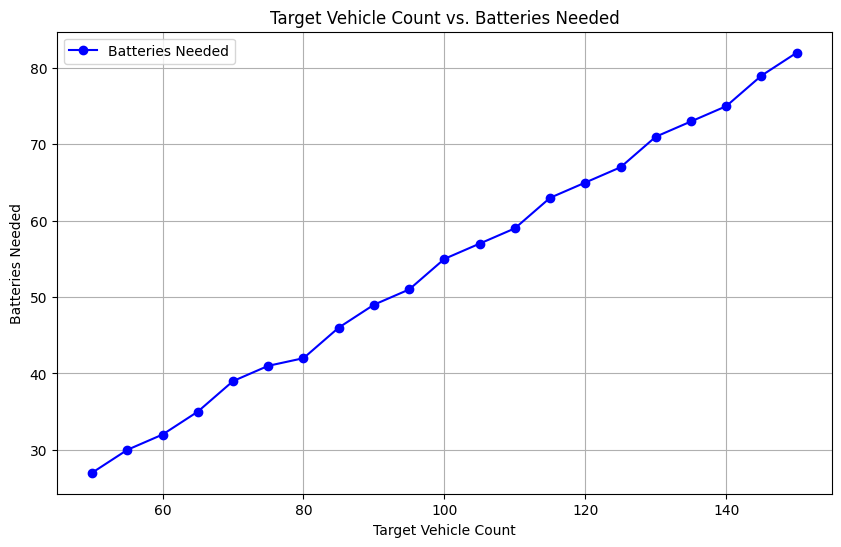

In [5]:
import matplotlib.pyplot as plt

def plot_batteries_needed_vs_vehicle_count(vehicle_counts, vehicles_per_hour, charging_time, swap_time, max_wait_time, num_slots):
    """
    Plot the required batteries as a function of target vehicle count.
    
    Parameters:
    - vehicle_counts: List of target vehicle counts to test.
    - vehicles_per_hour: Base array of hourly vehicle demand.
    - charging_time: Time taken to fully charge a battery (hours).
    - swap_time: Time taken per battery swap (hours).
    - max_wait_time: Maximum allowable wait time (hours).
    - num_slots: Number of swap slots for simultaneous swaps.
    """
    batteries_needed_list = []
    
    for count in vehicle_counts:
        # Scale vehicle demand to match current target vehicle count
        scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, count)
        
        # Calculate total service rate based on number of slots and swap time
        total_service_rate = num_slots / swap_time
        
        # Calculate required batteries for this target vehicle count
        batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time)
        batteries_needed_list.append(batteries_needed)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(vehicle_counts, batteries_needed_list, marker='o', color='b', label='Batteries Needed')
    plt.title("Target Vehicle Count vs. Batteries Needed")
    plt.xlabel("Target Vehicle Count")
    plt.ylabel("Batteries Needed")
    plt.grid()
    plt.legend()
    plt.show()

# Example usage of the plotting function
vehicle_counts = range(50, 151, 5)  # Range of target vehicle counts to test, e.g., from 50 to 150
plot_batteries_needed_vs_vehicle_count(vehicle_counts, vehicles_per_hour, charging_time, swap_time, max_wait_time, num_slots)


{'battery_cost': 4528908.641975309, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 1509636.2139917698, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
{'battery_cost': 4967190.12345679, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 1655730.0411522638, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900}
{'battery_cost': 5259377.777777778, 'charger_

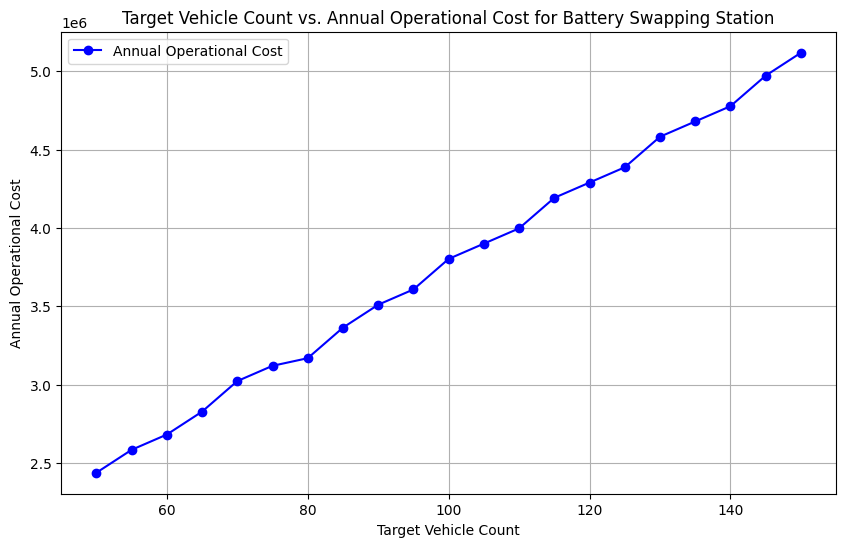

In [ ]:
import matplotlib.pyplot as plt

def plot_vehicle_count_vs_operational_cost(swapping_station_params, vehicle_counts, vehicles_per_hour, previous_num_batteries):
    annual_costs = []

    for vehicles in vehicle_counts:
        target_vehicle_count = vehicles  # Desired new total vehicle count
        scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, target_vehicle_count)

        # Run the calculation with scaled demand
        total_service_rate = num_slots / swap_time
        batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time) + 4
        
        # Update battery-related parameters based on the new battery requirement
        current_swapping_params = swapping_station_params.copy()  # Copy to avoid modifying the original
        current_swapping_params["battery_cost"] = (swapping_station_params["battery_cost"] / previous_num_batteries) * batteries_needed
        current_swapping_params["battery_replacement_cost"] = (swapping_station_params["battery_replacement_cost"] / previous_num_batteries) * batteries_needed

        # Calculate the annual operational cost and store it
        cost = calculate_swapping_station_annual_operational_cost(current_swapping_params)
        annual_costs.append(cost)

        # Update previous_num_batteries for the next iteration

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(vehicle_counts, annual_costs, marker='o', color='b', label='Annual Operational Cost')
    plt.title("Target Vehicle Count vs. Annual Operational Cost for Battery Swapping Station")
    plt.xlabel("Target Vehicle Count")
    plt.ylabel("Annual Operational Cost")
    plt.grid()
    plt.legend()
    plt.show()

# Example call to the function
vehicle_counts = range(50, 151, 5)
plot_vehicle_count_vs_operational_cost(swapping_station_params, vehicle_counts, vehicles_per_hour, batteries_needed)


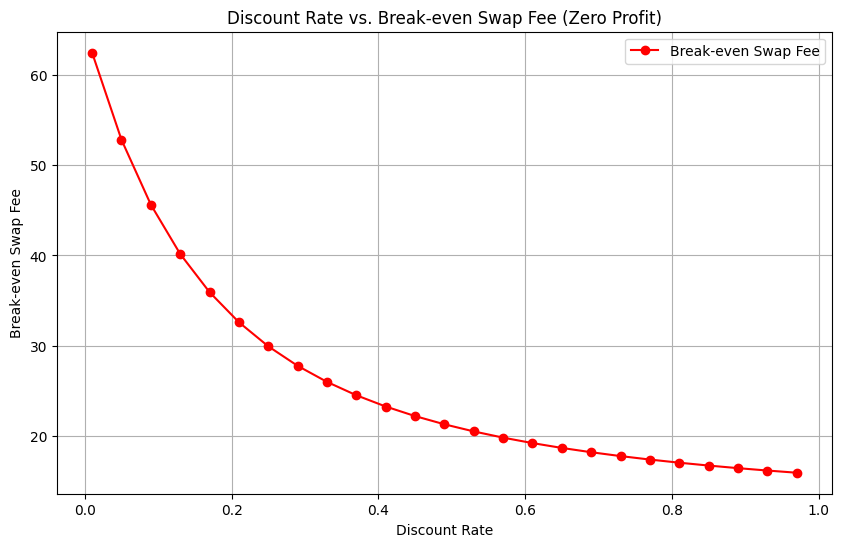

In [18]:
import matplotlib.pyplot as plt

def plot_discount_rate_vs_swap_fee_for_zero_profit(swapping_station_params, total_annual_swaps, initial_setup_cost_swapping, annual_operational_cost_swapping):
    # Range of discount rates to test
    discount_rates = np.arange(0.01, 1.0, 0.04)  # 1% to 20%
    swap_fees = []

    for rate in discount_rates:
        # Calculate total 10-year cost with the current discount rate
        total_10_year_cost = calculate_total_10_year_cost(initial_setup_cost_swapping, annual_operational_cost_swapping, years=10,discount_rate=rate)
        
        # Calculate break-even swap fee (desired profit set to zero)
        swap_fee = calculate_break_even_swap_fee(total_10_year_cost, total_annual_swaps, desired_profit=0)
        swap_fees.append(swap_fee)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(discount_rates, swap_fees, marker='o', color='r', label='Break-even Swap Fee')
    plt.title("Discount Rate vs. Break-even Swap Fee (Zero Profit)")
    plt.xlabel("Discount Rate")
    plt.ylabel("Break-even Swap Fee")
    plt.grid()
    plt.legend()
    plt.show()

# Example call to the function
plot_discount_rate_vs_swap_fee_for_zero_profit(swapping_station_params, total_annual_swaps, initial_setup_cost_swapping, annual_operational_cost_swapping)


{'battery_cost': 1240000.0, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 413333.3333333334, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900, 'batteries_needed': 45}
{'battery_cost': 1240000.0, 'charger_cost': 19500, 'land_cost': 187500, 'service_vehicle_cost': 120000, 'backup_power_system_cost': 70000, 'battery_management_software_cost': 295000, 'electrical_grid_connection_cost': 50000, 'infrastructure_construction_cost': 300000, 'maintenance_cost': 50000, 'worker_salaries': 720000, 'battery_replacement_cost': 413333.3333333334, 'backup_power_cost': 36500, 'miscellaneous_operational_costs': 30000, 'depreciation_costs': 92900, 'batteries_needed': 45}
{'battery_cost

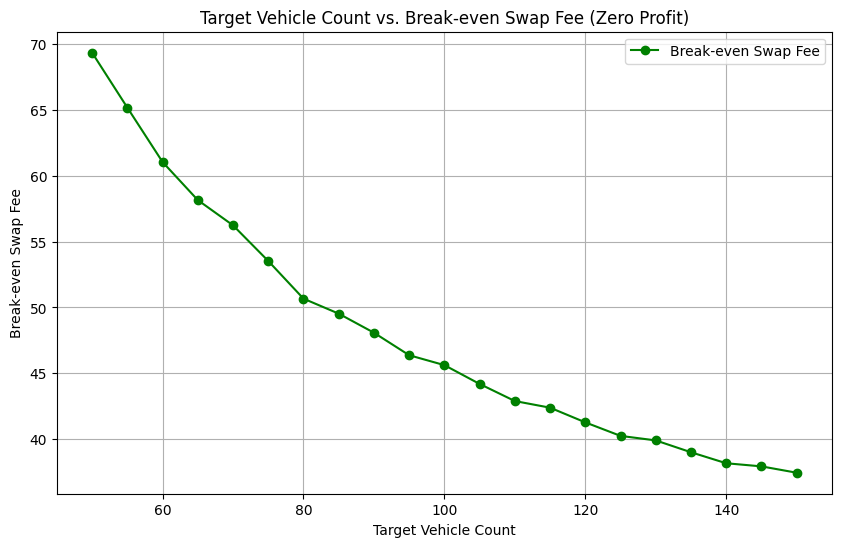

In [21]:
import matplotlib.pyplot as plt

def plot_vehicle_count_vs_break_even_swap_fee(swapping_station_params, vehicle_counts, vehicles_per_hour, previous_num_batteries):
    break_even_fees = []

    for vehicles in vehicle_counts:
        # Calculate total annual swaps based on target vehicle count
        total_annual_swaps = vehicles * 365  # Assume daily swapping
        target_vehicle_count = vehicles  # Desired new total vehicle count
        scaled_vehicles_per_hour = scale_vehicle_demand(vehicles_per_hour, target_vehicle_count)

        # Run the calculation with scaled demand
        total_service_rate = num_slots / swap_time
        batteries_needed = calculate_batteries_needed(scaled_vehicles_per_hour, charging_time, total_service_rate, max_wait_time) + 4
        
        # Update battery-related parameters based on the new battery requirement
        current_swapping_params = swapping_station_params.copy()  # Copy to avoid modifying the original
        current_swapping_params["battery_cost"] = (swapping_station_params["battery_cost"] / previous_num_batteries) * batteries_needed
        current_swapping_params["battery_replacement_cost"] = (swapping_station_params["battery_replacement_cost"] / previous_num_batteries) * batteries_needed

        # Calculate the annual operational cost and store it
        annual_cost = calculate_swapping_station_annual_operational_cost(current_swapping_params)
        setup_cost = calculate_swapping_station_setup_cost(current_swapping_params)

        total_10_year_cost = calculate_total_10_year_cost(setup_cost, annual_cost, years=10)
        
        # Calculate break-even swap fee (desired profit set to zero)
        swap_fee = calculate_break_even_swap_fee(total_10_year_cost, total_annual_swaps, desired_profit=0)
        break_even_fees.append(swap_fee)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(vehicle_counts, break_even_fees, marker='o', color='g', label='Break-even Swap Fee')
    plt.title("Target Vehicle Count vs. Break-even Swap Fee (Zero Profit)")
    plt.xlabel("Target Vehicle Count")
    plt.ylabel("Break-even Swap Fee")
    plt.grid()
    plt.legend()
    plt.show()

# Example call to the function
vehicle_counts = range(50, 151, 5)  # Define the range of target vehicle counts to test
plot_vehicle_count_vs_break_even_swap_fee(swapping_station_params, vehicle_counts, vehicles_per_hour,batteries_needed)
